In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

# Introduction

[Yelp.com](www.yelp.com) is a popular crowd-sourced local business review and social network site. It offers a platform where users can submit a review of the business using a one to five star rating system along with additional reviews. In this project, we are interested in the sentiment of reviews and trying to explore what could be potential useful factors to predict the sentiment. 

# Data Overview


All the data is retrieved using the Yelp Fusion API. We search for restaurants in 10 cities in the United States, namely Boston, Chicago, Miami, Minneapolis, Nashville, New Mexico, New York, Pittsburgh, San Francisco and Seattle. 

For each city, we collect at most 1,000 restaurants and at most 3 reviews (due to the API limitation) for each restaurant. There are in total 9915 restaurants and 29742 reviews. In additional to the review text and the review rating, we also retrieved other business-related information including the city location, overall  restaurant rating, category, price level and the total review count for each restaurant. Data are then preprocessed and stored in a dataframe. 

In [2]:
# load data into a panda dataframe
data = pd.read_pickle('complete_data')

# show first 2 row of the data
# data.head(2)

,review_id,restaurant_id,rating,text,city,category,restaurant_rating,price,review_count
0,MZRCnkRjWwilSI1tazv_3w,y2w6rFaO0XEiG5mFfOsiFA,5,The best lobster rolls in Boston. They give ve...,Boston,"(Seafood, Bars)",4.5,$$$,4041
1,D7rxX5QE1uHJ1rcHCRjRkA,y2w6rFaO0XEiG5mFfOsiFA,5,Amazing selection of oysters!! Hot lobster rol...,Boston,"(Seafood, Bars)",4.5,$$$,4041


# Exploratory Data Analysis


To begin with, we first perform a exploratory data analysis to get a through understading of our data and explore the relationship between each variables. 

We choose price, restaurant_rating, review_count and estimate (the estimated category) as explanatory variables, and rating as the response. In this section we will focus on the first three. 

In [3]:
# get categories
print("Price value:" + str(set(pd.Series.tolist(data['price']))))
print("Restaurant Rating: " + str(set(pd.Series.tolist(data['restaurant_rating']))))
print("Review Rating: " + str(set(pd.Series.tolist(data['rating']))))

Price value:{'$', '$$', '$$$$', '$$$'}
Restaurant Rating: {1.5, 2.5, 3.0, 3.5, 5.0, 4.5, 4.0, 2.0}
Review Rating: {1, 2, 3, 4, 5}


From the above outputs we see that price is a categorical variable with four levels: \$, \$\$, \$\$\$, \$\$\$\$. Restaurant_rating is also categorical with 8 categories: 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0. Review count is quantitative and takes values in positive integers. Then we will explore how each variable interact with the review rating.

# Statistical Analysis


We want to analyze the relationship between each of the three explanatory variables and the response. Since price and restaurant_rating are categorical, we will run chi-square test on them. 

In [4]:
# price ~ rating test
# get counts of combinations of different levels of price and rating
d = data.groupby(['price', 'rating']).size().reset_index(name='count')
p = pd.Series.tolist(d['price'])
prices = set(p)
r = pd.Series.tolist(d['rating'])
ratings = set(r)
c = pd.Series.tolist(d['count'])
l = [(p[i], r[i], c[i], 0) for i in range(len(p))]
for price in prices:
    for rating in ratings:
        # compute row total
        row = sum([z for (x, y, z, v) in l if y == rating])
        # compute column total
        col = sum([z for (x, y, z, v) in l if x == price])
        tot = sum([z for (x, y, z, v) in l])
        # compute expected for this entry
        exp = row*col/tot
        l1 = [(x, y, z, exp) for (x, y, z, v) in l if (x == price and y == rating)]
        l2 = [(x, y, z, v) for (x, y, z, v) in l if (x != price or y != rating)]
        l = l1+l2
# sum up (observed - expected)^2/expected
chisq = np.sum([(z-v)**2/v for (x, y, z, v) in l])
print('price ~ rating: ')
print('chi-squared stat: ' + str(chisq))
crit = stats.chi2.ppf(q = 0.95, df=(len(prices)-1)*(len(ratings)-1))
print('critical value: ' + str(crit))

price ~ rating: 
chi-squared stat: 147.38530044
critical value: 21.0260698175


Since chi-squared stat > critical value, we reject the null hypothesis and state there's a relationship between price and rating. 

#### Price - Rating Analysis 
We would like to analyze the relationship between price and review rating. From the visualization below, it turns out to be that the higher the resraurant price level is, the higher rating of each review for the restaurant. The resraurants in price \$$$$ level have larger proportion of 5 star review rating (more than half) and less propotion of 1 star review rating (nearly 5%) than others.
Also one thing can be inferred from this graph is that customers are more likely to give high ratings no matter what price level the resraurant is.

So that we can infer that the luxury restaurant tends to have higher review ratings and cheap restaurants also have this feature. But cheap restaurants have the largest propotion of 1 star ratings. While, the moderately priced restaurant have the relatively normal distribution. 

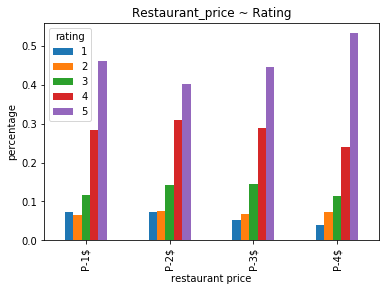

In [5]:
# price ~ rating
grouped = data.groupby(['price','rating'])
tmp = grouped.size().unstack(fill_value=0)
tmp = tmp.apply(lambda x: [c/x.sum() for c in x] ,axis=1)
tmp.index = ['P-1$','P-2$','P-3$','P-4$']
# print(tmp)
tmp.plot.bar()
plt.xlabel('restaurant price')
plt.ylabel('percentage')
plt.title('Restaurant_price ~ Rating')
plt.show()

In [6]:
# restaurant_rating ~ rating test
# get counts of combinations of different levels of restaurant_rating and rating
d = data.groupby(['restaurant_rating', 'rating']).size().reset_index(name='count')
rr = pd.Series.tolist(d['restaurant_rating'])
restaurant_ratings = set(rr)
r = pd.Series.tolist(d['rating'])
ratings = set(r)
c = pd.Series.tolist(d['count'])
l = [(rr[i], r[i], c[i], 0) for i in range(len(rr))]
for restaurant_rating in restaurant_ratings:
    for rating in ratings:
        # compute row total
        row = sum([z for (x, y, z, v) in l if y == rating])
        # compute column total
        col = sum([z for (x, y, z, v) in l if x == restaurant_rating])
        tot = sum([z for (x, y, z, v) in l])
        # compute expected for this entry
        exp = row*col/tot
        l1 = [(x, y, z, exp) for (x, y, z, v) in l if (x == restaurant_rating and y == rating)]
        l2 = [(x, y, z, v) for (x, y, z, v) in l if (x != restaurant_rating or y != rating)]
        l = l1+l2
# sum up (observed - expected)^2/expected
chisq = np.sum([(z-v)**2/v for (x, y, z, v) in l])
print('restaurant_rating ~ rating: ')
print('chi-squared stat: ' + str(chisq))
crit = stats.chi2.ppf(q = 0.95, df=(len(restaurant_ratings)-1)*(len(ratings)-1))
print('critical value: ' + str(crit))

restaurant_rating ~ rating: 
chi-squared stat: 3166.11505573
critical value: 41.3371381514


Since chi-squared stat > critical value, we reject the null hypothesis and state there's a relationship between restaurant_rating and rating. 

#### Restaurant rating - Review rating Analysis 
We would like to analyze the relationship between restaurant rating and review rating. From the visualization below, it turns out to be that the higher the resraurant total rating is, the higher rating of each review for the restaurant. The resraurants rating 5.0 have larger proportion of 5 star review rating, and the 5 star rating is descending from restaurant rating 5.0 to 1.5 in gerneral（the propotion of 5 star rating in 5.0 restaurant is above 80% while in 1.5-2.5 restaurants it is just less than 20%). On the other hand, the low review ratings propotion are increasing from restaurant rating 5.0 to 1.5 in gerneral (the propotion of 1 star rating in 5.0 restaurant is nearly zero while in 1.5-2.0 restaurants it is almost half) . So that we can infer that the high rating restaurant tends to have higher review ratings.

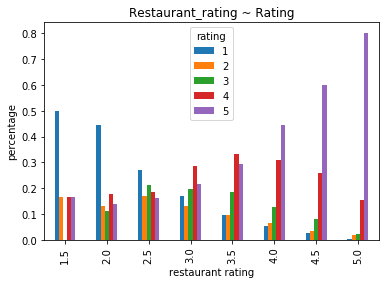

In [7]:
# restaurant_rating ~ rating
grouped = data.groupby([ 'restaurant_rating','rating'])
# print(grouped.size())
tmp = grouped.size().unstack(fill_value=0)
tmp = tmp.apply(lambda x: [c/x.sum() for c in x] ,axis=1)
# print(tmp)
tmp.plot.bar()
plt.xlabel('restaurant rating')
plt.ylabel('percentage')
plt.title('Restaurant_rating ~ Rating')
plt.show()

# MultinomialNB Classifer using only Review Text


In the original data, the review rating is of scale 1 to 5. Our goal is to classify if the review is positive or negative. Therefore we convert the score into a binary variable. If the orignal review rating is greater than 3, we treated it as a positive review, otherwise it's a negative review. 

In [8]:
# create sentiment label 
# if review rating > 3, it's positive, otherwise it's negative
data = pd.read_pickle('complete_data')
data['positive'] = np.where(data['rating'] > 3, 1, 0)

# create training data and label
x = data['text']
y = data['positive']

The original review text is messy and unprocessed. The first step is to clean up the text in order to build up a corpus. We transform all text to lower case, remove puntuations, non-english words, stop words and words shorter than 2 characters.

In [9]:
def text_preprocess(doc):
    stop = set(stopwords.words('english'))
    exclude = set(punctuation)
    lemma = WordNetLemmatizer()

    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = [lemma.lemmatize(word) for word in punc_free.split()]
    long_tokens = [token for token in normalized if len(token) >= 2]
    return long_tokens

Next we will transorm the clean review text to a term frequency table. In order not to overfit the data, we limit the size of the corpus by setting both the upper and lower bounds. Specifically, we only record tokens that appear in at least 2% and at most 95% of total reviews. In this way we both elimiate tokens that are too rare and too frequent. After processing, there are in total 123 tokens as the entire courpus. 

In [10]:
bow = CountVectorizer(analyzer=text_preprocess, min_df=0.02, max_df=0.95).fit(x)
clean_x = bow.transform(x)
print("Corpus Size:" + str(len(bow.vocabulary_)))

Corpus Size:123


We then divide the data into training, validation and testing with the ratio of 0.72 : 0.18 : 0.1. 

In [11]:
# split data into training and testing set
x_use, x_test , y_use, y_test = train_test_split(clean_x, y, test_size=0.1)
x_train, x_validate, y_train, y_validate = train_test_split(x_use, y_use, test_size=0.2)

Now we can start training a sentiment classifier using only the review text. We choose to use the simple Multinominal Naive Bayes classifier. We train the model on the training set and then test the prediction accuracy on the validation set. The validation accuracy can achieve around 71%. 

This is reasonable result. Although we are only using a small corpus and a simple model, most of the time it can still predict the correct sentiment. The reason behind this is that some of the tokens in the corpus provides strong sentiment indication, such as emotional adjectives. By merely looking at these terms it is not too hard to guess what the correct sentiment is. 

In [12]:
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_validate)

print("Naive Bayes Validation Accuracy: "+ str(accuracy_score(y_validate, y_pred)))

Naive Bayes Validation Accuracy: 0.71746031746


# Logistic Regression with Additional Variables


Next, we want to improve the sentiment prediction accuracy from the previous classifer. In the previous data exploratory and the statitical analysis session, we have already discovered that other information about the restaurant, such as the price level and the average restaurant rating, have some correlations with the average review rating. So we think adding these addtional information can help the model to perform better in classifying sentiment. 

We apply a Logistic regression model to combine all these features. Specifically, we have the same target label as before, which is a binary variable indicating if it is a positive or negative sentiment. Then we fit Multinomial Naive Bayes model using the processed review text. This Naive Bayes will produce a probability indicating the likelihood of being a positive sentiment. We use this probability as one of the independent variables. In addtion, we flatten the price variable into 3 dummy variables (Price contains 4 different types. We leave one out since we can infer the forth type by only looking at value the other three dummy variables). Finally we also include the average restaurant rating as an indepedent variable. 

So in total we have 5 indepedent variables. We build a logistic regression classifer using these input values. Again we split the data into training, validation and testing set with the same ratio. The classifer is trained using the training set and then measured performance using the validation set. 

On the validation set, this logistic regression achieves around 74% prediciton accuracy, which outperforms the Multi-Nominal Naive Bayes classifer by around 3%. So we believe that adding these additional features about the business can better help a classifer to indentify the sentiment of the review. 

In [13]:
from sklearn.linear_model import LogisticRegression

# divide price, restaurant into categories
data['estimate'] = nb.fit(clean_x, y).predict(clean_x)
df_price = pd.get_dummies(data['price'], drop_first=True)
data = pd.concat([data, df_price], axis=1)

data_subset = data[['$$','$$$','$$$$','restaurant_rating', 'estimate']]

# split data into training and testing set
subx_use, subx_test , suby_use, suby_test = train_test_split(data_subset, y, test_size=0.1)
subx_train, subx_validate, suby_train, suby_validate = train_test_split(subx_use, suby_use, test_size=0.2)

# # actual model
lr = LogisticRegression()
lr.fit(subx_train, suby_train)
suby_pred = lr.predict(subx_validate)
print("LR validation Accuracy: " + str(accuracy_score(suby_validate, suby_pred)))

LR validation Accuracy: 0.737628384687


In [14]:
y_pred_test = nb.predict(x_test)
sub_y_pred_test = lr.predict(subx_test)

print("Naive Bayes Test Accuracy: "+ str(accuracy_score(y_test, y_pred_test)))
print("Logistic Regression Test Accuracy: "+ str(accuracy_score(suby_test, sub_y_pred_test)))

Naive Bayes Test Accuracy: 0.73252688172
Logistic Regression Test Accuracy: 0.747311827957


# Summary

In this project, we are interested in the sentiment of the reviews on Yelp. we first did data collection which includes ten cities and 3 reviews for each cities using the Yelp API. After that, we did data pre-processing to merge the raw data into a dataframe where each entry include the review rating, review text, restaurant rating and restaurant price level and etc.

Then we did some explantory and statistical analysis to get a brief understanding of the data. Next we built a naive bayes classifier using only review text that achieves around 71% prediction sentiment accuracy. By incorporating the results (predicted categories) from the NB classifier into a logistic regression model with other explanatory variables, the prediction accuracy improves to around 74%. 